In [1]:
%run ./Definitions.ipynb

2019-12-19 15:42:16.574524
thunder  Thu Dec 19 15:42:16 2019
[0] GeForce GTX 1080 Ti | 39'C,   0 % |  1476 / 11178 MB | hemelinr(1466M)
[1] GeForce GTX 1080 Ti | 25'C,   0 % |  4556 / 11178 MB | hemelinr(4546M)
[2] GeForce GTX 1080 Ti | 27'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 45'C,  25 % |  8605 / 11178 MB | patra(8595M)
[4] GeForce GTX 1080 Ti | 25'C,   0 % |  4759 / 11178 MB | hemelinr(4546M) srikanth(203M)
[5] GeForce GTX 1080 Ti | 27'C,   0 % | 10799 / 11178 MB | gerritsn(10789M)
[6] GeForce GTX 1080 Ti | 37'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 47'C,   0 % | 10895 / 11178 MB | patra(10885M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "6"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

Thu Dec 19 15:42:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   39C    P2    56W / 250W |   1476MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |   4556MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]=='0']
glaucoma = X[X[Class]=='1']

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# Converting class values to int 1 or 0
upsampled[Class] = upsampled[Class].astype(int)

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

In [9]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

## Define Model and Metrics

In [10]:
reg_value=0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:71]:
        layer.trainable = False
    for layer in mobile_conv.layers[71:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
     # Add the vgg convolutional base model
    model.add(mobile_conv)

    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [11]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [12]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)


Found 198910 validated image filenames.
Found 33943 validated image filenames.


In [13]:
# which_model = make_model
which_model = mobilenet_model
# which_model = vgg_model
model = which_model()

learning_rate  = 0.0001 
decay = 1e-5
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,858,049
Non-trainable params: 1,371,840
_________________________________________________________________


In [14]:
# With L2 weight regularizer
es = EarlyStopping(monitor='val_F1', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_F1', factor=0.2, patience=10, min_lr=0.000001, verbose=1)
n_epochs=150
n_steps_per_epoch = 50
n_validation_steps = 10

In [15]:
start = time.time()
history = model.fit_generator(train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/150
50/50 [==============================] - 24s 486ms/step - loss: 0.7035 - Accuracy: 0.5719 - Precision: 0.5688 - Recall: 0.5624 - F1: 0.5568 - AUC: 0.6067 - val_loss: 1.6287 - val_Accuracy: 0.0250 - val_Precision: 0.0157 - val_Recall: 0.4000 - val_F1: 0.0301 - val_AUC: 0.6025
Epoch 2/150
50/50 [==============================] - 21s 426ms/step - loss: 0.6691 - Accuracy: 0.6313 - Precision: 0.6447 - Recall: 0.6745 - F1: 0.6513 - AUC: 0.6662 - val_loss: 1.2536 - val_Accuracy: 0.0688 - val_Precision: 0.0324 - val_Recall: 0.5000 - val_F1: 0.0602 - val_AUC: 0.7037
Epoch 3/150
50/50 [==============================] - 23s 459ms/step - loss: 0.6463 - Accuracy: 0.6425 - Precision: 0.6395 - Recall: 0.6521 - F1: 0.6387 - AUC: 0.6907 - val_loss: 0.7846 - val_Accuracy: 0.5938 - val_Precision: 0.0402 - val_Recall: 0.3333 - val_F1: 0.0697 - val_AUC: 0.5305
Epoch 4/150
50/50 [==============================] - 21s 421ms/step - loss: 0.6380 - Accuracy: 0.6519 - Precision: 0.6557 - Recall: 0.65

Epoch 57/150
50/50 [==============================] - 22s 446ms/step - loss: 0.4922 - Accuracy: 0.7719 - Precision: 0.7643 - Recall: 0.7989 - F1: 0.7750 - AUC: 0.8483 - val_loss: 0.8731 - val_Accuracy: 0.3875 - val_Precision: 0.0278 - val_Recall: 0.5000 - val_F1: 0.0522 - val_AUC: 0.6417
Epoch 58/150
50/50 [==============================] - 22s 449ms/step - loss: 0.5065 - Accuracy: 0.7600 - Precision: 0.7594 - Recall: 0.7927 - F1: 0.7689 - AUC: 0.8332 - val_loss: 0.8413 - val_Accuracy: 0.3812 - val_Precision: 0.0333 - val_Recall: 0.5000 - val_F1: 0.0621 - val_AUC: 0.6440
Epoch 59/150
50/50 [==============================] - 22s 444ms/step - loss: 0.4925 - Accuracy: 0.7700 - Precision: 0.7909 - Recall: 0.7724 - F1: 0.7739 - AUC: 0.8508 - val_loss: 0.8832 - val_Accuracy: 0.3688 - val_Precision: 0.0375 - val_Recall: 0.6000 - val_F1: 0.0699 - val_AUC: 0.6108
Epoch 60/150
50/50 [==============================] - 22s 446ms/step - loss: 0.4916 - Accuracy: 0.7744 - Precision: 0.7651 - Recall: 

50/50 [==============================] - 22s 435ms/step - loss: 0.4980 - Accuracy: 0.7650 - Precision: 0.7417 - Recall: 0.8119 - F1: 0.7666 - AUC: 0.8426 - val_loss: 0.8492 - val_Accuracy: 0.3125 - val_Precision: 0.0301 - val_Recall: 0.5167 - val_F1: 0.0561 - val_AUC: 0.4591
Epoch 114/150
50/50 [==============================] - 23s 452ms/step - loss: 0.5043 - Accuracy: 0.7544 - Precision: 0.7622 - Recall: 0.7670 - F1: 0.7600 - AUC: 0.8329 - val_loss: 0.8615 - val_Accuracy: 0.2969 - val_Precision: 0.0364 - val_Recall: 0.5667 - val_F1: 0.0678 - val_AUC: 0.6089
Epoch 115/150
50/50 [==============================] - 22s 437ms/step - loss: 0.4957 - Accuracy: 0.7656 - Precision: 0.7469 - Recall: 0.8022 - F1: 0.7674 - AUC: 0.8431 - val_loss: 0.9651 - val_Accuracy: 0.3187 - val_Precision: 0.0185 - val_Recall: 0.3000 - val_F1: 0.0347 - val_AUC: 0.5222
Epoch 116/150
50/50 [==============================] - 22s 446ms/step - loss: 0.4998 - Accuracy: 0.7581 - Precision: 0.7497 - Recall: 0.7858 - F

In [16]:
print("Time taken:",end-start)

Time taken: 3344.4256896972656


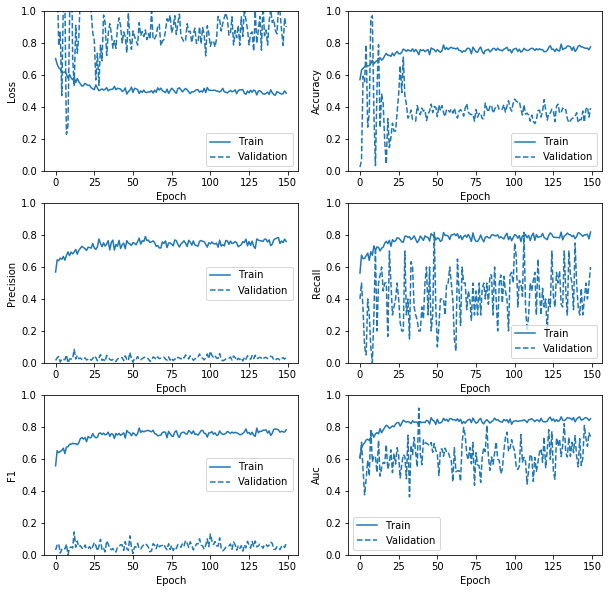

In [17]:
plt.figure(figsize=(10,10))
plot_metrics(history)

## Evaluation

In [18]:
results_tr = model.evaluate(train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 16s 161ms/step


In [19]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))


NAME :	TRAIN :	VALIDATION 
loss : 0.567 :   0.813
Accuracy : 0.553 :   0.358
Precision : 0.527 :   0.028
Recall : 0.925 :   0.430
F1 : 0.666 :   0.052
AUC : 0.638 :   0.569


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [ ]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

In [27]:
# TRUE LABELS

train_labels = upsampled[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


In [28]:
np.save(funduspath_CR + str(n_epochs) + 'ep_81_pred_tr.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_81_pred_vl.npy', pred_vl)

### ROC Curve

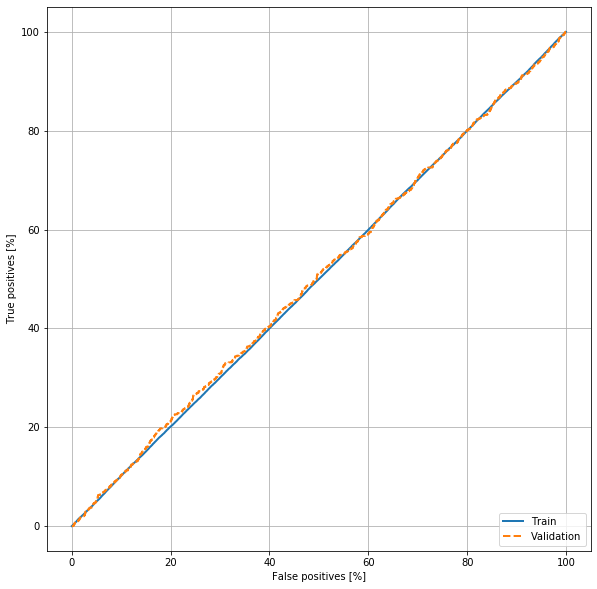

In [29]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 12773 
FP: 86682 
FN: 12727 
TP: 86728
Healthy Patients - correctly identified (True Negatives):  12773 0.1284299431903876
Healthy Patients - predicted to have glaucoma (False Positives):  86682 0.8715700568096124
Glaucoma Patients - predicted healthy (False Negatives):  12727 0.1279674224523654
Glaucoma Patients - correctly identified (True Positives):  86728 0.8720325775476346

Total Glaucoma patients:  99455 1.0
Total Healthy patients:  99455 1.0


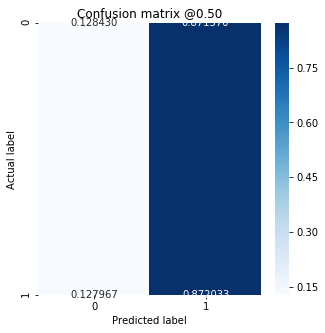

In [39]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 11516 
FP: 21618 
FN: 277 
TP: 532
Healthy Patients - correctly identified (True Negatives):  11516 0.34755839922737974
Healthy Patients - predicted to have glaucoma (False Positives):  21618 0.6524416007726203
Glaucoma Patients - predicted healthy (False Negatives):  277 0.34239802224969096
Glaucoma Patients - correctly identified (True Positives):  532 0.657601977750309

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


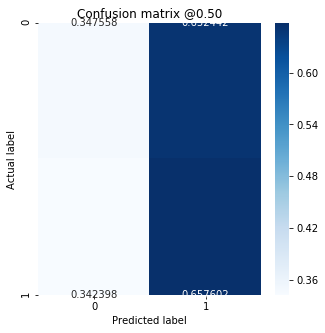

In [40]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [45]:
# history = imb_history
tag_value = "single train on balanced data 71 layers"

exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
keras_model_path = funduspath_CR+ exp_name + '_model'
save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
            n_epochs,n_steps_per_epoch,n_validation_steps,
            reg_value,learning_rate,decay,opt,
            history,results_tr,results_vl,train_cm,val_cm
           )

<IPython.core.display.Javascript object>

In [46]:
# client = MlflowClient()
# run = client.create_run('13')
# client.set_tag(run.info.run_id, "tag_key", tag_value)